In [1]:
!pip install scikit-learn feature_engine scikit-plot

In [2]:
import sqlite3
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from feature_engine import imputation
from feature_engine import encoding
from sklearn.pipeline import Pipeline
from sklearn import tree, ensemble, metrics


In [3]:
def import_query(path):
    with open(path, 'r') as file:
        query = file.read()
    return query

In [4]:
db_origin = sqlite3.connect(r'C:\Adam\Programação\Projetos\IA\MLGC\data\silver_gc.db')
query_abt = import_query(r'C:\Adam\Programação\Projetos\IA\MLGC\src\targetedFeatures.sql')

df_total = pd.read_sql(query_abt, db_origin)

max_date = df_total.dtRef.max()

df_oot = df_total.query("dtRef == @max_date").copy() # out of time base
df_train = df_total.query("dtRef < @max_date").copy() # train base

# SEMMA
## Sample

In [5]:
columns = df_total.columns
target = ['flNaoChurn']
ids = ['dtRef', 'idPlayer']
to_remove = ['flAssinatura']

features = list(set(columns) - set(target) - set(ids) - set(to_remove))

In [6]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[features], df_train[target], test_size=0.2, random_state=42)

# Explore

In [7]:
X_train.dtypes[X_train.dtypes == 'object']

descMedal    object
dtype: object

In [8]:
# missing values

missing_columns = X_train.count()[X_train.count() < X_train.shape[0]].index.sort_values(ascending=True).to_list()
missing_flag = [
    'WinRate',
    'avg1Kill',
    'avg2Kill',
    'avg3Kill',
    'avg4Kill',
    'avg5Kill',
    'avgAssist',
    'avgBombeDefuse',
    'avgBombePlant',
    'avgClutchWon',
    'avgDamage',
    'avgDeath',
    'avgFirstKill',
    'avgFlashAssist',
    'avgHitChest',
    'avgHitHeadshot',
    'avgHitLeftAtm',
    'avgHitLeftLeg',
    'avgHitRightArm',
    'avgHitRightLeg',
    'avgHitStomach',
    'avgHits',
    'avgHs',
    'avgHsRate',
    'avgKill',
    'avgLastAlive',
    'avgPlusKill',
    'avgRoundsPlayed',
    'avgShots',
    'avgSurvived',
    'avgTk',
    'avgTkAssist',
    'avgTrade',
    'qtRecencia',
    'vlHsRate',
    'vlLevel',
]

missing_zero = [
    'avgTrade',
    'propAncient',
    'propDias00',
    'propDias01',
    'propDias02',
    'propDias03',
    'propDias04',
    'propDias05',
    'propDias06',
    'propDust2',
    'propInferno',
    'propMirage',
    'propNuke',
    'propOverpass',
    'propTrain',
    'propVertigo',
    'qtDias',
    'qtPartidas',
]

cat_features = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

In [9]:
print(cat_features)

['descMedal']


In [10]:
print(X_train.isna().sum())

avgFirstKill       2364
propNuke           2364
propInferno        2364
avgRoundsPlayed    2364
propAncient        2364
                   ... 
qtMedal               0
avgHitLeftLeg      2364
avgFlashAssist     2364
avg4Kill           2364
vlLevel            2364
Length: 62, dtype: int64


## Modify

In [56]:
fe_missing_flag = imputation.ArbitraryNumberImputer(variables=missing_flag,
                                                    arbitrary_number=-100)

fe_missing_zero = imputation.ArbitraryNumberImputer(variables=missing_zero,
                                                    arbitrary_number=0)

fe_onehot = encoding.OneHotEncoder(variables=cat_features)

params = {
    "min_samples_leaf": [10, 25, 50],
    "n_estimators": [50, 100, 250, 500]
}

model = ensemble.RandomForestClassifier(random_state=42)

grid_model = model_selection.GridSearchCV(model, params, n_jobs=-1, scoring='roc_auc', cv=3, verbose=3)

model_pipeline = Pipeline([("Missing flag", fe_missing_flag),
                           ("Missing 0", fe_missing_zero),
                           ("OneHotEnconder", fe_onehot),
                           ("Classificador", grid_model),
                           ])


model_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\adam_\anaconda3\envs\mlgc\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Pipeline(steps=[('Missing flag',
                 ArbitraryNumberImputer(arbitrary_number=-100,
                                        variables=['WinRate', 'avg1Kill',
                                                   'avg2Kill', 'avg3Kill',
                                                   'avg4Kill', 'avg5Kill',
                                                   'avgAssist',
                                                   'avgBombeDefuse',
                                                   'avgBombePlant',
                                                   'avgClutchWon', 'avgDamage',
                                                   'avgDeath', 'avgFirstKill',
                                                   'avgFlashAssist',
                                                   'avgHitChest',
                                                   'avgHitHeadshot',
                                                   'avgHitLeftAtm',
                                                   'avgHitLeftLeg',
                                                   'avgHitRightArm',
                                                   'av...
                                                   'propInferno', 'propMirage',
                                                   'propNuke', 'propOverpass',
                                                   'propTrain', 'propVertigo',
                                                   'qtDias', 'qtPartidas'])),
                ('OneHotEnconder', OneHotEncoder(variables=['descMedal'])),
                ('Classificador',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'min_samples_leaf': [10, 25, 50],
                                          'n_estimators': [50, 100, 250, 500]},
                              scoring='roc_auc', verbose=3))])

In [57]:
cv_results = pd.DataFrame(grid_model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.346368,0.073817,0.178515,0.031932,10,50,"{'min_samples_leaf': 10, 'n_estimators': 50}",0.972034,0.975869,0.970303,0.972735,0.002326,4
1,12.576627,0.097660,0.300030,0.032324,10,100,"{'min_samples_leaf': 10, 'n_estimators': 100}",0.973049,0.977627,0.971220,0.973965,0.002694,3
2,30.908526,0.385199,0.710804,0.013654,10,250,"{'min_samples_leaf': 10, 'n_estimators': 250}",0.974365,0.978547,0.972426,0.975112,0.002554,2
3,65.661242,1.499244,1.517182,0.227189,10,500,"{'min_samples_leaf': 10, 'n_estimators': 500}",0.974624,0.979032,0.972297,0.975318,0.002793,1
4,5.155833,0.131862,0.139425,0.007429,25,50,"{'min_samples_leaf': 25, 'n_estimators': 50}",0.955763,0.962054,0.952359,0.956725,0.004016,8
5,10.743879,0.409140,0.328839,0.090109,25,100,"{'min_samples_leaf': 25, 'n_estimators': 100}",0.957193,0.963705,0.954055,0.958317,0.004019,7
6,29.703598,0.684245,0.685024,0.090114,25,250,"{'min_samples_leaf': 25, 'n_estimators': 250}",0.958624,0.965710,0.955522,0.959952,0.004264,6
7,57.835234,3.143384,1.071504,0.165646,25,500,"{'min_samples_leaf': 25, 'n_estimators': 500}",0.958778,0.966385,0.954980,0.960048,0.004741,5
8,4.815945,0.222641,0.145846,0.027286,50,50,"{'min_samples_leaf': 50, 'n_estimators': 50}",0.930860,0.941186,0.927335,0.933127,0.005878,12
9,10.084292,0.612210,0.267076,0.031705,50,100,"{'min_samples_leaf': 50, 'n_estimators': 100}",0.931764,0.944451,0.926388,0.934201,0.007573,11


In [58]:
y_predict_train = model_pipeline.predict(X_train)

acc_train = metrics.accuracy_score(y_train, y_predict_train)
print(f"Acurácia de treino: {acc_train}")

Acurácia de treino: 0.9594733242134063


In [59]:
y_predict_test = model_pipeline.predict(X_test)
y_probas = model_pipeline.predict_proba(X_test)
y_probas_oot = model_pipeline.predict_proba(df_oot[features])

acc_test = metrics.accuracy_score(y_test, y_predict_test)
print(f"Acurácia de teste: {acc_test}")

Acurácia de teste: 0.929792568953727


In [ ]:
# features_fit = model_pipeline[:-1].transform(X_train).columns.tolist()

# features_importance = pd.Series(model.feature_importances_, index=features_fit)
# features_importance.sort_values(ascending=False).head(15)

<Axes: title={'center': 'oot'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

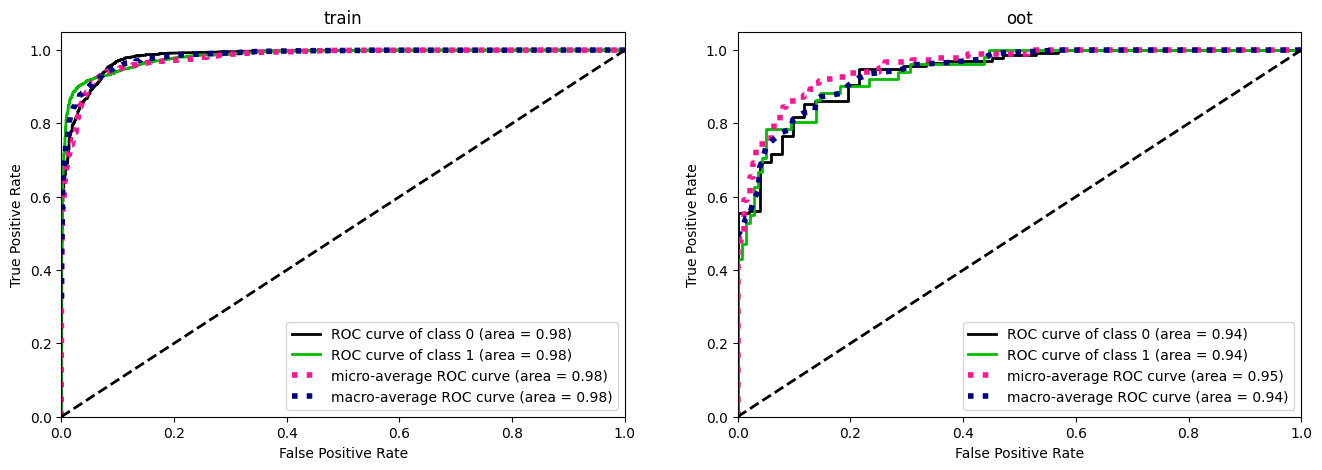

In [61]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

skplt.metrics.plot_roc(y_test, y_probas, ax=ax[0], title='train')
skplt.metrics.plot_roc(df_oot[target], y_probas_oot, ax=ax[1], title='oot')

c:\Users\adam_\anaconda3\envs\mlgc\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\adam_\anaconda3\envs\mlgc\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: title={'center': 'oot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

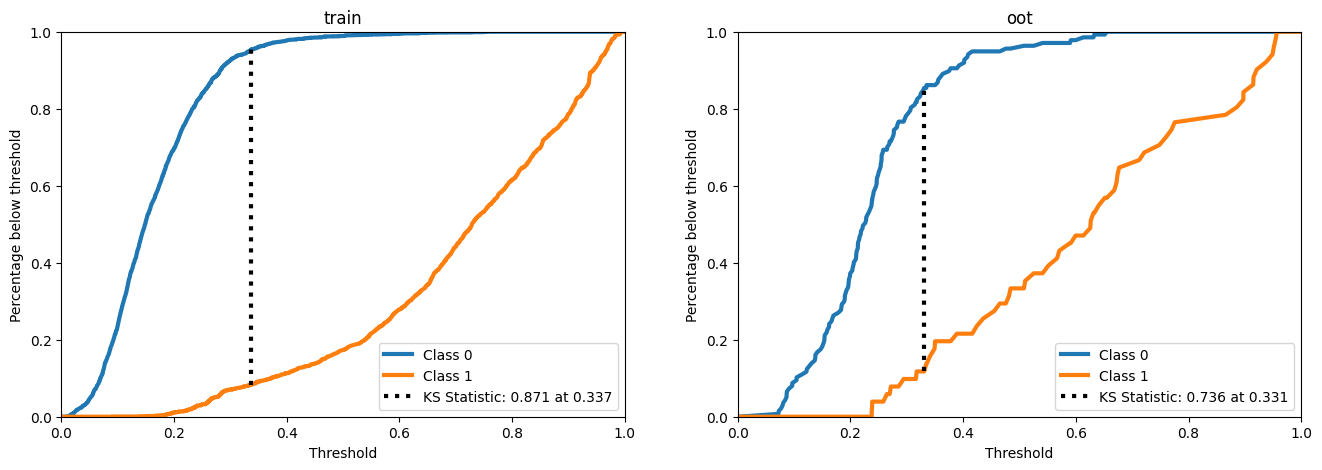

In [62]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

skplt.metrics.plot_ks_statistic(y_test, y_probas, title='train', ax=ax[0])
skplt.metrics.plot_ks_statistic(df_oot[target], y_probas_oot, title='oot', ax=ax[1])

<Axes: title={'center': 'oot'}, xlabel='Percentage of sample', ylabel='Gain'>

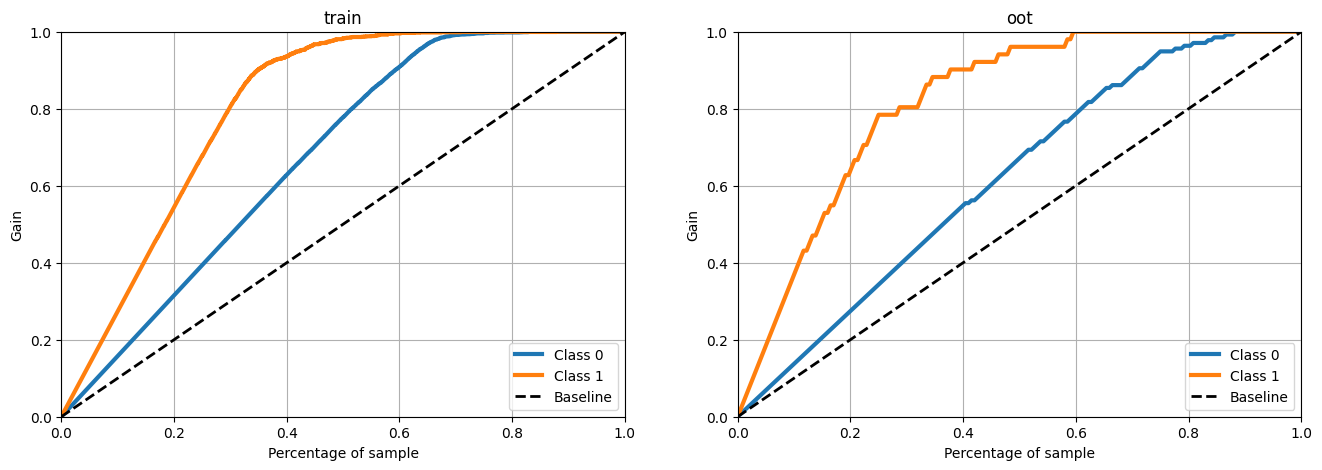

In [63]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

skplt.metrics.plot_cumulative_gain(y_test, y_probas, title='train', ax=ax[0])
skplt.metrics.plot_cumulative_gain(df_oot[target], y_probas_oot, title='oot', ax=ax[1])

<Axes: title={'center': 'oot'}, xlabel='Percentage of sample', ylabel='Lift'>

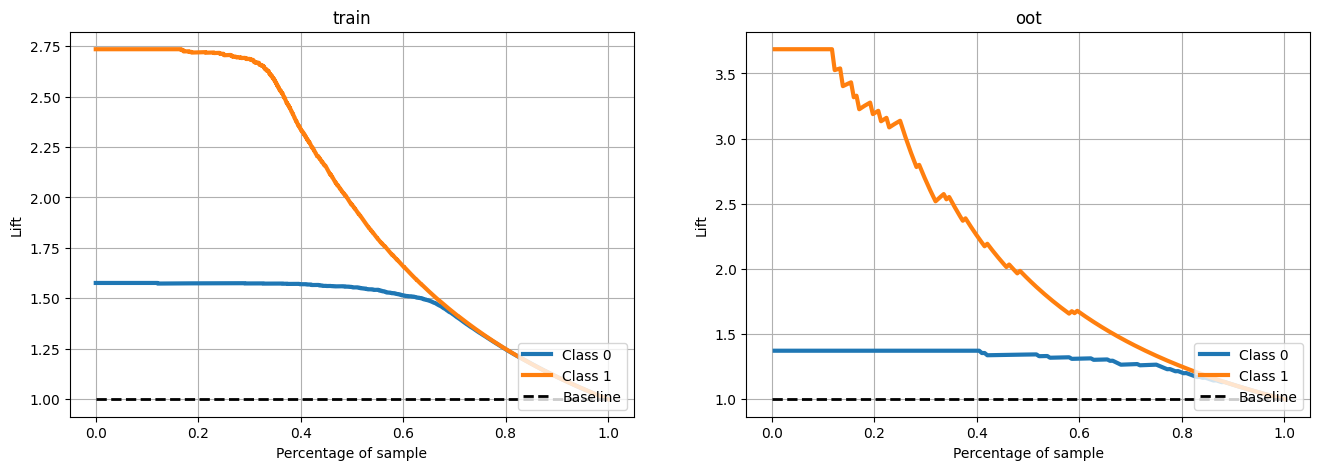

In [64]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

skplt.metrics.plot_lift_curve(y_test, y_probas, title='train', ax=ax[0])
skplt.metrics.plot_lift_curve(df_oot[target], y_probas_oot, title='oot', ax=ax[1])